In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [79]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Imputing Missing Data

This time around, I'll be imputing `Age` and `Fare` in more detail. In theory, I won't know which data points will be missing, so I'll have to write the code that expects missing `Age` and `Fare` data and imputes them automatically.

In [80]:
imputation_agg = [
    'mean',
    'median',
    'count'
]

# Make a copy for analysis
impute_df = df_train.copy()

impute_df.groupby('Sex').Age.agg(imputation_agg)

,mean,median,count
Sex,,,
female,27.915709,27.0,261
male,30.726645,29.0,453


In [81]:
def extract_title(data):
    # Titles
    title_dict = {
        "Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
            "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
            "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
            "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona": "Royalty"
    }
    Title_raw = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    return Title_raw.map(title_dict)

In [82]:
impute_df['Title'] = extract_title(impute_df)
impute_df.groupby('Title').Age.agg(imputation_agg)

,mean,median,count
Title,,,
Master,4.574167,3.5,36
Miss,21.804054,21.0,148
Mr,32.368090,30.0,398
Mrs,35.718182,35.0,110
Officer,56.600000,56.0,5
Royalty,42.294118,44.0,17


In [83]:
impute_df.groupby('Pclass').Age.mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [84]:
def impute_age(data, imputed_age_values):
    return imputed_age_values.loc[
        (imputed_age_values.Sex == data.Sex)
        & (imputed_age_values.Title == data.Title)
        & (imputed_age_values.Pclass == data.Pclass)
        & (imputed_age_values.Parch == data.Parch)
    ]

In [85]:
impute_df.groupby(['Pclass', 'Embarked']).Fare.agg(imputation_agg)

mean   median  count
Pclass Embarked                            
1      C         104.718529  78.2667     85
       Q          90.000000  90.0000      2
       S          70.364862  52.0000    127
2      C          25.358335  24.0000     17
       Q          12.350000  12.3500      3
       S          20.327439  13.5000    164
3      C          11.214083   7.8958     66
       Q          11.183393   7.7500     72
       S          14.644083   8.0500    353

In [86]:
def impute_fare(data, imputed_fare_values):
    return imputed_fare_values.loc[
        (imputed_fare_values.Pclass == data.Pclass)
        & (imputed_fare_values.Embarked == data.Embarked)
    ]

# Other Fields

I also want to see if I can do anything with the `Ticket` and `Cabin` fields.

In [87]:
df_train.Ticket.value_counts().sort_values(ascending=False).head(20)

347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
4133            4
347077          4
19950           4
2666            4
W./C. 6608      4
113781          4
113760          4
349909          4
17421           4
PC 17757        4
LINE            4
35273           3
Name: Ticket, dtype: int64

# Feature Engineering / Data Cleaning

Given what I've learned about imputing `Age` and `Fare`, I'll be updating my `clean_data` function.

In [88]:
import re

# Utility Functions
def one_hot_encoding(data, field):
    ohe_fields = pd.get_dummies(data[field], prefix=field)
    for col in ohe_fields.columns.sort_values()[1:]:
        data[col] = ohe_fields[col]
    return data

# Clean Ticket
def clean_ticket(ticket_id):
    if ticket_id.isnumeric():
        return 'numeric'
    else:
        # return re.sub('[^A-Za-z]', '', ticket_id)
        return 'alphanumeric'

# Clean Cabin
def clean_cabin(cabin_id):
    if type(cabin_id) == float:
        return 'numeric'
    else:
        # return re.sub('[^A-Za-z]', '', cabin_id)
        return 'alphanumeric'

In [89]:
def clean_data(data):
    """
    Function for cleaning data
    """

    data_return = data.copy()

    # Create title field
    data_return['Title'] = extract_title(data_return)

    # Feature Engineer Ticket
    data_return['Ticket_split'] = data_return.Ticket.apply(lambda x: clean_ticket(x))

    # Feature Engineer Cabin
    data_return['Cabin_split'] = data_return.Cabin.apply(lambda x: clean_cabin(x))

    # Impute Age
    imputed_age_values = data_return.groupby(['Sex', 'Title', 'Pclass', 'Parch']).Age.mean()
    data_return['Age_cleaned'] = data_return.apply(lambda x: x.Age if pd.notna(x.Age) else imputed_age_values[x.Sex][x.Title][x.Pclass][x.Parch], axis=1)

    # Impute Age (Test Only)
    imputed_age_values_test = data_return.groupby(['Sex']).Age_cleaned.mean()
    data_return['Age_cleaned'] = data_return.apply(lambda x: x.Age_cleaned if pd.notna(x.Age_cleaned) else imputed_age_values_test[x.Sex], axis=1)

    # Impute Fare
    imputed_fare_values = data.groupby(['Pclass', 'Embarked']).Fare.mean()
    data_return['Fare_cleaned'] = data_return.apply(lambda x: x.Fare if pd.notna(x.Fare) else imputed_fare_values[x.Pclass][x.Embarked], axis=1)
    data_return['Fare_cleaned**2'] = data_return['Fare_cleaned']**2
    
    # One-Hot Encoding
    data_return = one_hot_encoding(data_return, 'Title')
    data_return = one_hot_encoding(data_return, 'Embarked')
    data_return = one_hot_encoding(data_return, 'Sex')
    data_return = one_hot_encoding(data_return, 'Ticket_split')
    data_return = one_hot_encoding(data_return, 'Cabin_split')

    # Interaction variables
    data_return['Sex_and_Parch'] = data_return.Sex_male * data_return.Parch
    data_return['SibSp_and_Parch'] = data_return.SibSp * data_return.Parch
    data_return['Sex_and_Pclass'] = data_return.Sex_male * data_return.Pclass
    data_return['Sex_and_Fare'] = data_return.Sex_male * data_return.Fare_cleaned

    # Normalize Age + Fare
    data_return.Age_cleaned = (data_return.Age_cleaned - data_return.Age_cleaned.mean()) / data_return.Age_cleaned.std()
    data_return.Fare_cleaned = (data_return.Fare_cleaned - data_return.Fare_cleaned.mean()) / data_return.Fare_cleaned.std()

    # Drop columns
    dropped_columns = [
        'PassengerId',
        'Ticket',
        'Ticket_split',
        'Cabin',
        'Cabin_split',
        'Name',
        'Title',
        'Sex',
        'Embarked',
        'Age',
        'Fare'
    ]

    data_return.drop(dropped_columns, axis=1, inplace=True)

    return data_return

In [90]:
df_train_cleaned = clean_data(df_train)
df_train_cleaned.head()

,Survived,Pclass,SibSp,Parch,Age_cleaned,Fare_cleaned,Fare_cleaned**2,Title_Miss,Title_Mr,Title_Mrs,...,Title_Royalty,Embarked_Q,Embarked_S,Sex_male,Ticket_split_numeric,Cabin_split_numeric,Sex_and_Parch,SibSp_and_Parch,Sex_and_Pclass,Sex_and_Fare
0,0,3,1,0,-0.552874,-0.502163,52.562500,0,1,0,...,0,0,1,1,0,1,0,0,3,7.25
1,1,1,1,0,0.628214,0.786404,5081.308859,0,0,1,...,0,0,0,0,0,0,0,0,0,0.00
2,1,3,0,0,-0.257602,-0.488580,62.805625,1,0,0,...,0,0,1,0,0,1,0,0,0,0.00
3,1,1,1,0,0.406760,0.420494,2819.610000,0,0,1,...,0,0,1,0,1,0,0,0,0,0.00
4,0,3,0,0,0.406760,-0.486064,64.802500,0,1,0,...,0,0,1,1,1,1,0,0,3,8.05


In [91]:
test_data = pd.read_csv('data/test.csv')
test_data_cleaned = clean_data(test_data)
test_data_cleaned.head()

,Pclass,SibSp,Parch,Age_cleaned,Fare_cleaned,Fare_cleaned**2,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_Q,Embarked_S,Sex_male,Ticket_split_numeric,Cabin_split_numeric,Sex_and_Parch,SibSp_and_Parch,Sex_and_Pclass,Sex_and_Fare
0,3,0,0,0.364189,-0.496790,61.296373,0,1,0,0,0,1,0,1,1,1,0,0,3,7.8292
1,3,1,0,1.325197,-0.511637,49.000000,0,0,1,0,0,0,1,0,1,1,0,0,0,0.0000
2,2,0,0,2.478406,-0.463518,93.847656,0,1,0,0,0,1,0,1,1,1,0,0,2,9.6875
3,3,0,0,-0.212416,-0.481870,75.038906,0,1,0,0,0,0,1,1,1,1,0,0,3,8.6625
4,3,1,1,-0.596819,-0.416965,150.982656,0,0,1,0,0,0,1,0,1,1,0,1,0,0.0000


In [92]:
# Ensure all columns are available in both
missing_in_trained = list(set(test_data_cleaned.columns) - set(df_train_cleaned.columns))
missing_in_test = list(set(df_train_cleaned.columns) - set(test_data_cleaned.columns))

for col in missing_in_trained:
    if col not in df_train_cleaned.columns:
        df_train_cleaned[col] = 0

for col in missing_in_test:
    if col not in test_data_cleaned.columns:
        test_data_cleaned[col] = 0

In [93]:
list(set(df_train_cleaned.columns) - set(test_data_cleaned.columns))

[]

In [94]:
list(set(test_data_cleaned.columns) - set(df_train_cleaned.columns))

[]

In [95]:
df_train_cleaned.columns

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Age_cleaned', 'Fare_cleaned',
       'Fare_cleaned**2', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Embarked_Q', 'Embarked_S',
       'Sex_male', 'Ticket_split_numeric', 'Cabin_split_numeric',
       'Sex_and_Parch', 'SibSp_and_Parch', 'Sex_and_Pclass', 'Sex_and_Fare'],
      dtype='object')

In [96]:
test_data_cleaned.drop('Survived', axis=1, inplace=True)

# Model Selection

In my previous attempt, I only used Logistic Regression with an L2 regularization. The default solver for both `statsmodels` and `scikit-learn` is maximum likelihood and L-BFGS respectively. 

Since `statsmodels` doesn't have a validation suite, I can't easily use k-Folds without building something on my own. For now, I'll use `scikit-learn` and play around with the model hyperparameters using `GridSearchCV`.

Theoretically, L1 and L2 work similarly, except L1 forces the coefficients to be 0, making L1 norm more preferrable as it works similar to best subset selection. However, I'll check both just to see if there are any differences.

Cross Validation Score Mean after Repeated K-Fold: 82.92%
Cross Validation Score Std. Dev. after Repeated K-Fold: 0.03


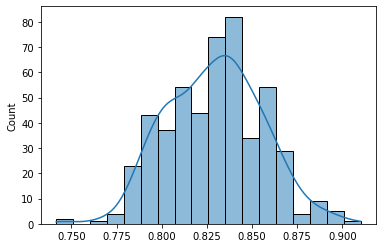

In [105]:
X = df_train_cleaned.drop('Survived', axis=1).copy()
y = df_train_cleaned.Survived.copy()

cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=654237)
m01 = LogisticRegression(penalty='l1', solver='liblinear', C=2.782559402207126)
m01.fit(X, y)

scores = cross_val_score(m01, X, y, scoring='accuracy', cv=cv, n_jobs=-10)

sns.histplot(x=scores, kde=True)

print('Cross Validation Score Mean after Repeated K-Fold: {:0.2f}%'.format(np.mean(scores)*100))
print('Cross Validation Score Std. Dev. after Repeated K-Fold: {:0.2f}'.format(np.std(scores)))

In [98]:
param_grid = [
    {
        'penalty' : ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 10),
        'solver' : ['liblinear']
    }
]

log_reg_grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10)
log_reg_grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [99]:
log_reg_grid_search.best_params_

{'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'liblinear'}

In [100]:
log_reg_grid_search.best_score_

0.835043695380774

In [101]:
m02 = LogisticRegression(
    penalty=log_reg_grid_search.best_params_['penalty'],
    solver=log_reg_grid_search.best_params_['solver'],
    C=log_reg_grid_search.best_params_['C']
)

m02.fit(X, y)

LogisticRegression(C=2.782559402207126, penalty='l1', solver='liblinear')

In [102]:
# @TODO: Create logit statsmodels with best hyper-parameters above and analyze results
# Check for linearity between predictor and logit
smf.logit(data=df_train_cleaned)

# Exporting Results

In [103]:
m02_test_pred = m02.predict(test_data_cleaned)
m02_test_pred[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [104]:
m02_test_pred_df = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': m02_test_pred})
m02_test_pred_df.to_csv('submissions/20220511_submission.csv', index=False)